# Chapter 7: Multiple Regression Analysis with Qualitative Regressors

:::{important} Learning Objectives
:class: dropdown

Upon completion of this chapter, readers will demonstrate proficiency in categorical variable analysis using Python by:

**7.1** Creating dummy variables from categorical data using pandas get_dummies and patsy C() categorical coding functions.

**7.2** Estimating regression models with multiple category indicators and interpreting coefficients as group mean differences using statsmodels.

**7.3** Implementing interaction terms between dummy and continuous variables using patsy formula syntax with colon operators.

**7.4** Conducting Chow tests for structural breaks through F-tests comparing restricted and unrestricted models with statsmodels.

**7.5** Estimating linear probability models (LPM) and computing heteroskedasticity-robust standard errors appropriate for binary outcomes.

**7.6** Implementing difference-in-differences estimators for program evaluation using interaction terms between time and treatment dummies.

**7.7** Visualizing group differences and interactions through categorical plots using seaborn catplot and interaction_plot functions.

**7.8** Conducting post-estimation hypothesis tests for coefficient equality across groups using wald_test methods.
:::

Incorporating categorical variables into regression models enables researchers to analyze the impact of non-numeric factors such as gender, marital status, occupation, or geographic region on economic outcomes. This chapter develops the theory and practice of using dummy variables (indicator variables) to represent qualitative factors numerically, allowing their inclusion alongside quantitative regressors in the OLS framework.

The presentation builds systematically from basic dummy variable techniques to advanced applications. We begin with binary dummy variables and their interpretation as intercept shifts (Section 7.1), extend to categorical variables with multiple categories (Section 7.2), examine interaction terms between qualitative and quantitative variables allowing for slope differences (Section 7.3), address the linear probability model for binary dependent variables (Section 7.4-7.6), develop difference-in-differences methods for program evaluation (Section 7.7), and conclude with the Chow test for structural breaks (Section 7.8). Throughout, we implement these methods using Python's statsmodels library with real datasets from applied econometric research.

In [1]:
import matplotlib.pyplot as plt
import numpy as np  # noqa: F401
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import wooldridge as wool
from scipy import stats

## 7.1 Linear Regression with Dummy Variables as Regressors

Dummy variables (also called indicator variables or binary variables) take on the value 1 or 0 to indicate the presence or absence of a specific attribute or category. In regression analysis, they are used to include qualitative information in a quantitative framework.

**Key Concepts:**

1. **Reference Category (Base Category):** When including a dummy variable, one category is always omitted and serves as the **reference category** or **base category**. All coefficient interpretations are relative to this reference group.

2. **Interpretation:** The coefficient on a dummy variable represents the difference in the expected value of the dependent variable between the category indicated by the dummy (when dummy=1) and the reference category (when dummy=0), holding all other variables constant.

3. **Dummy Variable Trap:** For a categorical variable with $g$ categories, we include only $g-1$ dummy variables in the regression. Including all $g$ dummies would cause perfect multicollinearity (violating MLR.3) because the dummies would sum to the constant term.

**Example:** If we have a gender variable with categories "male" and "female", we create one dummy variable:
- `female = 1` if female, `female = 0` if male
- **Reference category:** male (when `female = 0`)
- **Coefficient interpretation:** $\beta_{female}$ represents the expected difference in $y$ between females and males, holding other variables constant. If $\beta_{female} = -1.81$ in a wage equation, this means females earn \$1.81 less per hour than males (the reference group), on average, ceteris paribus.

### Example 7.1: Hourly Wage Equation

In this example, we will investigate how gender affects hourly wages, controlling for education, experience, and tenure. We will use the `wage1` dataset from the `wooldridge` package. The dataset includes information on wages, education, experience, tenure, and gender (female=1 if female, 0 if male).

In [2]:
# Load wage dataset for dummy variable analysis
wage1 = wool.data("wage1")

# Examine the gender variable
# GENDER DISTRIBUTION IN DATASET
# Dataset size
pd.DataFrame(
    {
        "Metric": ["Total observations"],
        "Value": [len(wage1)],
    }
)

# Gender distribution details
gender_dist = pd.DataFrame(
    {
        "Gender": ["Males (female=0)", "Females (female=1)"],
        "Count": [(wage1["female"] == 0).sum(), (wage1["female"] == 1).sum()],
        "Percentage": [
            f"{(wage1['female'] == 0).mean():.1%}",
            f"{(wage1['female'] == 1).mean():.1%}",
        ],
    }
)
gender_dist

# Estimate model with dummy variable for gender
dummy_model = smf.ols(
    formula="wage ~ female + educ + exper + tenure",
    data=wage1,
)
dummy_results = dummy_model.fit()

# Create enhanced results table with interpretations
results_table = pd.DataFrame(
    {
        "Coefficient": dummy_results.params.round(4),
        "Std_Error": dummy_results.bse.round(4),
        "t_statistic": dummy_results.tvalues.round(3),
        "p_value": dummy_results.pvalues.round(4),
        "Interpretation": [
            "Baseline wage ($/hr) for males with zero education/experience",
            "Gender wage gap: females earn $1.81/hr less than males",
            "Return to education: $0.57/hr per year of schooling",
            "Return to experience: $0.03/hr per year",
            "Return to tenure: $0.14/hr per year with current employer",
        ],
    },
)

# REGRESSION RESULTS: WAGE EQUATION WITH GENDER DUMMY
# Dependent Variable: wage (hourly wage in dollars)
# Reference Category: male (female=0)
results_table
# Model statistics
pd.DataFrame(
    {
        "Metric": ["R-squared", "Number of observations"],
        "Value": [f"{dummy_results.rsquared:.4f}", int(dummy_results.nobs)],
    }
)

,Metric,Value
0,R-squared,0.3635
1,Number of observations,526


**Explanation:**

- `wage ~ female + educ + exper + tenure`: This formula specifies the regression model. We are regressing `wage` (hourly wage) on `female` (dummy variable for gender), `educ` (years of education), `exper` (years of experience), and `tenure` (years with current employer).
- `smf.ols(...)`: This function from `statsmodels.formula.api` performs Ordinary Least Squares (OLS) regression.
- `results.fit()`: This fits the regression model to the data.
- The printed table displays the regression coefficients (`b`), standard errors (`se`), t-statistics (`t`), and p-values (`pval`) for each regressor.

**Interpretation of Results:**

- **Intercept (const):** The estimated intercept is -1.5679 (dollars per hour). This is the predicted wage for the **reference group** (male, since `female=0`) with zero years of education, experience, and tenure. While not practically meaningful in this context (as education, experience, and tenure are rarely zero simultaneously), it's a necessary part of the regression model that establishes the baseline.
  
- **female:** The coefficient for `female` is -1.8109 (dollars per hour). **Reference category interpretation:** Holding education, experience, and tenure constant, women (`female=1`) earn, on average, \$1.81 less per hour than **men** (`female=0`, the reference category) in this dataset. The negative coefficient indicates a wage gap between women and men, with women being the lower-earning group relative to the male baseline.
- **educ:** The coefficient for `educ` is 0.5715. This means that, holding other factors constant, each additional year of education is associated with an increase in hourly wage of approximately \$0.57.
- **exper:** The coefficient for `exper` is 0.0254. For each additional year of experience, hourly wage is predicted to increase by about \$0.025, holding other factors constant.
- **tenure:** The coefficient for `tenure` is 0.1410. For each additional year of tenure with the current employer, hourly wage is predicted to increase by about \$0.14, holding other factors constant.

- **P-values:** The p-values for `female`, `educ`, `exper`, and `tenure` are all small (0.0309 or less), indicating that these variables are statistically significant at conventional significance levels (e.g., 0.05 or 0.01).

This simple example demonstrates how dummy variables can be used to quantify the effect of qualitative factors like gender on a dependent variable like wages in a multiple regression framework.

### Example 7.6: Log Hourly Wage Equation

Using the logarithm of the dependent variable, such as wage, is common in economics. When the dependent variable is in log form, the coefficients on the regressors (after multiplying by 100) can be interpreted as approximate percentage changes in the dependent variable for a one-unit change in the regressor.

In this example, we will use the natural logarithm of hourly wage as the dependent variable and explore the interaction effect between marital status and gender, along with education, experience, and tenure (including quadratic terms for experience and tenure to capture potential non-linear relationships).

In [3]:
wage1 = wool.data("wage1")

reg = smf.ols(
    formula="np.log(wage) ~ married*female + educ + exper +"
    "I(exper**2) + tenure + I(tenure**2)",
    data=wage1,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table  # Display regression results

,b,se,t,pval
Intercept,0.3214,0.1000,3.2135,0.0014
married,0.2127,0.0554,3.8419,0.0001
female,-0.1104,0.0557,-1.9797,0.0483
married:female,-0.3006,0.0718,-4.1885,0.0000
educ,0.0789,0.0067,11.7873,0.0000
exper,0.0268,0.0052,5.1118,0.0000
I(exper ** 2),-0.0005,0.0001,-4.8471,0.0000
tenure,0.0291,0.0068,4.3016,0.0000
I(tenure ** 2),-0.0005,0.0002,-2.3056,0.0215


**Explanation:**

- `np.log(wage) ~ married*female + educ + exper + I(exper**2) + tenure + I(tenure**2)`:
  - `np.log(wage)`: The dependent variable is now the natural logarithm of `wage`.
  - `married*female`: This includes the main effects of `married` and `female` as well as their interaction term (`married:female`). The interaction term allows us to see if the effect of being female differs depending on marital status (or vice versa).
  - `I(exper**2)` and `I(tenure**2)`: We use `I(...)` to include squared terms of `exper` and `tenure` in the formula. This allows for a quadratic relationship between experience/tenure and log wage, capturing potential diminishing returns to experience and tenure.

**Interpretation of Results (with Interaction Terms):**

When interpreting interaction terms involving dummy variables, we must be careful to identify the reference category at each step:

- **Intercept (const):** The intercept is 0.3214. This is the predicted log wage for the **baseline reference group**: single males (married=0, female=0) with zero education, experience, and tenure.

- **married:** The coefficient for `married` is 0.2127. **Interpretation:** Married males earn approximately $100 \times 0.2127 \approx 21.3\%$ more than **single males** (the reference group), holding other factors constant. (For small coefficients $|\beta| < 0.1$, the percentage change is approximately $100\beta$; for larger coefficients, use $100[\exp(\beta)-1]$, which here gives $100[\exp(0.2127)-1] \approx 23.7\%$).

- **female:** The coefficient for `female` is -0.1104. **Interpretation:** Single females (female=1, married=0) earn approximately $11.0\%$ less than **single males** (female=0, married=0, the reference group), holding other factors constant.

- **married:female:** The interaction term `married:female` has a coefficient of -0.3006. **Interpretation:** This captures the **additional** effect of being married for females, beyond the main effects. To find the total wage difference between married females and married males:
  - Effect of female when married = $\beta_{female} + \beta_{married:female} = -0.1104 + (-0.3006) = -0.4110$
  - Married females earn approximately $100 \times (-0.4110) \approx 41.1\%$ less than **married males**, holding other factors constant.
  
**Summary of all four groups relative to baseline (single males):**
- Single males (reference): 0% (baseline)
- Married males: $+21.3\%$ (coefficient on `married`)
- Single females: $-11.0\%$ (coefficient on `female`)
- Married females: $-11.0\% + 21.3\% - 30.1\% = -19.8\%$ (sum of all three dummy coefficients)
- **educ, exper, I(exper**2), tenure, I(tenure**2):** These coefficients represent the effects of education, experience, and tenure on log wage, controlling for gender and marital status. For example, the coefficient for `educ` (0.0789) suggests that each additional year of education is associated with approximately a 7.89% increase in hourly wage, holding other factors constant. The negative coefficient on `I(exper**2)` suggests diminishing returns to experience.

- **P-values:** Most variables, including the interaction term `married:female`, are statistically significant at conventional levels, indicating that marital status and gender, both individually and in interaction, play a significant role in explaining wage variations.

## 7.2 Boolean variables

In Python (and programming in general), boolean variables are often used to represent true/false or yes/no conditions. In the context of regression with dummy variables, a boolean variable that is `True` or `False` can directly correspond to 1 or 0, respectively.

In the `wage1` dataset, the `female` variable is already coded as 1 for female and 0 for male. We can explicitly create a boolean variable, although it is not strictly necessary in this case as `statsmodels` and regression formulas in general can interpret 1/0 variables as dummy variables.

In [4]:
wage1 = wool.data("wage1")

# regression with boolean variable:
wage1["isfemale"] = wage1["female"] == 1
reg = smf.ols(formula="wage ~ isfemale + educ + exper + tenure", data=wage1)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table  # Display regression results

,b,se,t,pval
Intercept,-1.5679,0.7246,-2.1640,0.0309
isfemale[T.True],-1.8109,0.2648,-6.8379,0.0000
educ,0.5715,0.0493,11.5836,0.0000
exper,0.0254,0.0116,2.1951,0.0286
tenure,0.1410,0.0212,6.6632,0.0000


**Explanation:**

- `wage1["isfemale"] = wage1["female"] == 1`: This line creates a new column named `isfemale` in the `wage1` DataFrame. It assigns `True` to `isfemale` if the value in the `female` column is 1 (meaning female), and `False` otherwise. In essence, `isfemale` is a boolean representation of the `female` dummy variable.
- `reg = smf.ols(formula="wage ~ isfemale + educ + exper + tenure", data=wage1)`: We then run the same regression as in Example 7.1, but now using `isfemale` instead of `female` in the formula.

**Interpretation of Results:**

The regression table will be virtually identical to the one in Example 7.1. The coefficient, standard error, t-statistic, and p-value for `isfemale` will be the same as for `female` in the previous example.

**Key takeaway:**

Using a boolean variable (`isfemale`) that evaluates to `True` or `False` is functionally equivalent to using a dummy variable coded as 1 or 0 in regression analysis with `statsmodels`. `statsmodels` internally handles boolean `True` as 1 and `False` as 0 in regression formulas when they are used as regressors. Therefore, creating an explicit boolean variable like `isfemale` here doesn't change the regression outcome compared to directly using the 1/0 coded `female` variable.

## 7.3 Categorical Variables

Categorical variables represent groups or categories, and they can have more than two categories. Examples include occupation, industry, region, or education levels (e.g., high school, bachelor's, master's, PhD). To include categorical variables in a regression model, we typically use dummy variable encoding. If a categorical variable has _k_ categories, we include _k-1_ dummy variables in the regression to avoid perfect multicollinearity (the dummy variable trap). One category is chosen as the "reference" or "baseline" category, and the coefficients on the dummy variables represent the difference in the dependent variable between each category and the reference category, holding other regressors constant.

In this section, we will use the `cps78_85` dataset from the Wooldridge package, which contains data from the Current Population Survey for 1978 and 1985. We will investigate how gender, region (south/non-south), and union membership affect wages, controlling for education and experience.

In [5]:
cps = wool.data("cps78_85")

# Create categorical gender variable for clearer output
cps["gender"] = cps["female"].map({0: "male", 1: "female"})
cps["region"] = cps["south"].map({0: "non-south", 1: "south"})
cps["union_member"] = cps["union"].map({0: "non-union", 1: "union"})

# table of categories and frequencies for categorical variables:
freq_gender = pd.crosstab(cps["gender"], columns="count")
# Gender distribution
freq_gender

freq_region = pd.crosstab(cps["region"], columns="count")
# Region distribution
freq_region

freq_union = pd.crosstab(cps["union_member"], columns="count")
# Union membership distribution
freq_union

col_0,count
union_member,
non-union,820
union,264


**Explanation:**

- `cps = wool.data("cps78_85")`: Loads the CPS dataset from the Wooldridge package containing data from 1978 and 1985.
- `cps["gender"] = cps["female"].map({0: "male", 1: "female"})`: Creates a categorical gender variable from the binary `female` indicator for more readable output.
- `cps["region"] = cps["south"].map({0: "non-south", 1: "south"})`: Creates a categorical region variable from the binary `south` indicator.
- `cps["union_member"] = cps["union"].map({0: "non-union", 1: "union"})`: Creates a categorical union membership variable.
- `pd.crosstab(...)`: This pandas function creates cross-tabulation tables, which are useful for displaying the frequency of each category in categorical variables.

**Output:**

The frequency tables show the counts for each category in the dataset, giving us an overview of the distribution of these categorical variables across the sample.

In [6]:
# directly using categorical variables in regression formula:
reg = smf.ols(
    formula="lwage ~ educ + exper + C(gender) + C(region) + C(union_member)",
    data=cps,
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table  # Display regression results

,b,se,t,pval
Intercept,0.3019,0.0863,3.4967,0.0005
C(gender)[T.male],0.2499,0.0287,8.7002,0.0000
C(region)[T.south],-0.0703,0.0313,-2.2462,0.0249
C(union_member)[T.union],0.1416,0.0338,4.1929,0.0000
educ,0.0924,0.0056,16.5717,0.0000
exper,0.0123,0.0012,10.4979,0.0000


**Explanation:**

- `formula="lwage ~ educ + exper + C(gender) + C(region) + C(union_member)"`:
  - `C(gender)`, `C(region)`, and `C(union_member)`: The `C()` function in `statsmodels` formula language tells the regression function to treat these as categorical variables. `statsmodels` will automatically create dummy variables for each category except for the reference category. By default, `statsmodels` will choose the first category in alphabetical order as the reference category. For `gender`, 'female' will be the reference; for `region`, 'non-south' will be the reference; and for `union_member`, 'non-union' will be the reference.

**Interpretation of Results:**

- **Reference Categories:** The reference categories are 'female' for gender, 'non-south' for region, and 'non-union' for union membership.
- **C(gender)[T.male]:** The coefficient represents the log wage difference between males and females, holding education, experience, region, and union membership constant. If positive and significant, males earn more than females on average.
- **C(region)[T.south]:** Represents the log wage difference between individuals in the south and non-south regions, holding other variables constant.
- **C(union_member)[T.union]:** Represents the log wage difference between union and non-union workers, holding other variables constant. This is often called the "union wage premium."
- **educ and exper:** The coefficients represent the effect of each additional year of education or experience on log wage, holding gender, region, union membership, and the other variable constant.
- **P-values:** Small p-values indicate that the corresponding variable is a statistically significant predictor of log wage.

In [7]:
# rerun regression with different reference category:
reg_newref = smf.ols(
    formula="lwage ~ educ + exper + "
    'C(gender, Treatment("male")) + '
    'C(region, Treatment("south"))',
    data=cps,
)
results_newref = reg_newref.fit()

# print results:
table_newref = pd.DataFrame(
    {
        "b": round(results_newref.params, 4),
        "se": round(results_newref.bse, 4),
        "t": round(results_newref.tvalues, 4),
        "pval": round(results_newref.pvalues, 4),
    },
)
# Results with new reference category
table_newref

,b,se,t,pval
Intercept,0.5133,0.0838,6.1247,0.0000
"C(gender, Treatment(""male""))[T.female]",-0.2675,0.0286,-9.3454,0.0000
"C(region, Treatment(""south""))[T.non-south]",0.0893,0.0312,2.8644,0.0043
educ,0.0912,0.0056,16.2555,0.0000
exper,0.0130,0.0012,11.0586,0.0000


**Explanation:**

- `C(gender, Treatment("male"))`: Here, we explicitly specify "male" as the reference category for the `gender` variable using `Treatment("male")` within the `C()` function. Now, the coefficient for `C(gender)[T.female]` will represent the log wage difference between females and males (with males as the baseline).
- `C(region, Treatment("south"))`: Similarly, we set "south" as the reference category for the `region` variable. The coefficient for `C(region)[T.non-south]` will now represent the log wage difference between non-south and south regions.

**Interpretation of Results:**

- **Reference Categories (Changed):** Now, 'male' is the reference category for gender, and 'south' is the reference category for region.
- **C(gender)[T.female]:** The coefficient now represents the log wage difference between females and males, with males being the reference group. This will have the opposite sign compared to the `C(gender)[T.male]` coefficient from the previous regression.
- **C(region)[T.non-south]:** The coefficient represents the log wage difference between non-south and south regions, with south being the reference group.
- **educ and exper:** The coefficients remain unchanged regardless of which reference category is chosen for the categorical variables.

**Key takeaway:**

By using `C()` and `Treatment()`, we can easily incorporate categorical variables into our regression models and control which category serves as the reference group. The interpretation of the coefficients for categorical variables is always in comparison to the chosen reference category.

### 7.3.1 ANOVA Tables

ANOVA (Analysis of Variance) tables in regression context help to assess the overall significance of groups of regressors. They decompose the total variance in the dependent variable into components attributable to different sets of regressors. In the context of categorical variables, ANOVA tables can be used to test the joint significance of all dummy variables representing a categorical variable.

In [8]:
cps = wool.data("cps78_85")
# Create categorical variables
cps["gender"] = cps["female"].map({0: "male", 1: "female"})
cps["region"] = cps["south"].map({0: "non-south", 1: "south"})

# run regression:
reg = smf.ols(
    formula="lwage ~ educ + exper + gender + region + union",
    data=cps,
)
results = reg.fit()

# print regression table:
table_reg = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table_reg  # Display regression results

,b,se,t,pval
Intercept,0.3019,0.0863,3.4967,0.0005
gender[T.male],0.2499,0.0287,8.7002,0.0000
region[T.south],-0.0703,0.0313,-2.2462,0.0249
educ,0.0924,0.0056,16.5717,0.0000
exper,0.0123,0.0012,10.4979,0.0000
union,0.1416,0.0338,4.1929,0.0000


**Explanation:**

- `formula="lwage ~ educ + exper + gender + region + union"`: In this formula, we are directly using `gender` and `region` as categorical variables without explicitly using `C()`. `statsmodels` can automatically detect categorical variables (especially string or object type columns) and treat them as such in the regression formula, creating dummy variables behind the scenes. The `union` variable is binary (0/1), so it enters directly as a dummy variable. However, it is generally better to be explicit and use `C()` for clarity and control, especially when you want to specify reference categories.

In [9]:
# ANOVA table:
table_anova = sm.stats.anova_lm(results, typ=2)
# ANOVA table
table_anova

,sum_sq,df,F,PR(>F)
gender,16.068961,1.0,75.693756,1.219566e-17
region,1.071082,1.0,5.045394,2.489335e-02
educ,58.298916,1.0,274.620358,4.053952e-55
exper,23.395644,1.0,110.206510,1.296544e-24
union,3.732147,1.0,17.580490,2.979901e-05
Residual,228.847678,1078.0,NaN,NaN


**Explanation:**

- `table_anova = sm.stats.anova_lm(results, typ=2)`: This function from `statsmodels.stats` calculates the ANOVA table for the fitted regression model (`results`). `typ=2` specifies Type II ANOVA, which is generally recommended for regression models, especially when there might be some imbalance in the design (which is common in observational data).

**Interpretation of ANOVA Table:**

The ANOVA table output will typically include columns like:

- **df (degrees of freedom):** For each regressor (or group of regressors).
- **sum_sq (sum of squares):** The sum of squares explained by each regressor (or group of regressors).
- **mean_sq (mean square):** Mean square = sum_sq / df.
- **F (F-statistic):** F-statistic for testing the null hypothesis that all coefficients associated with a particular regressor (or group of regressors) are jointly zero.
- **PR(>F) (p-value):** The p-value associated with the F-statistic.

**For example, in the ANOVA table output:**

- **gender:** The row for `gender` will give you an F-statistic and a p-value. This tests the null hypothesis that _gender has no effect on log wage, once education, experience, region, and union membership are controlled for_. A small p-value (e.g., < 0.05) would suggest that gender is a statistically significant factor in explaining wage variation, even after controlling for other variables.
- **region:** Similarly, the row for `region` will test the significance of the region indicator. It tests the null hypothesis that _region has no effect on log wage, once education, experience, gender, and union membership are controlled for_. A small p-value would indicate that region is a significant factor.
- **union:** The row for `union` tests whether union membership significantly affects log wages after controlling for other variables.
- **educ and exper:** ANOVA table also provides F-tests for `educ` and `exper`, testing their significance in the model.
- **Residual:** This row represents the unexplained variance (residuals) in the model.

**Key takeaway:**

ANOVA tables provide F-tests for the joint significance of regressors, especially useful for categorical variables with multiple dummy variables. They help assess the overall contribution of each set of regressors to explaining the variation in the dependent variable.

## 7.4 Breaking a Numeric Variable Into Categories

Sometimes, it might be useful to convert a continuous numeric variable into a categorical variable. This can be done for several reasons:

- **Non-linear effects:** If you suspect that the effect of a numeric variable is not linear, categorizing it can capture non-linearities without explicitly modeling a complex functional form.
- **Easier interpretation:** Categorical variables can sometimes be easier to interpret, especially when dealing with ranges or levels of a variable.
- **Dealing with outliers or extreme values:** Grouping extreme values into categories can reduce the influence of outliers.

### Example 7.8: Effects of Law School Rankings on Starting Salaries

In this example, we will examine the effect of law school rankings on starting salaries of graduates. The `lawsch85` dataset from `wooldridge` contains information on law school rankings (`rank`), starting salaries (`salary`), LSAT scores (`LSAT`), GPA, library volumes (`libvol`), and cost (`cost`).

In [10]:
lawsch85 = wool.data("lawsch85")

# define cut points for the rank:
cutpts = [0, 10, 25, 40, 60, 100, 175]

# create categorical variable containing ranges for the rank:
lawsch85["rc"] = pd.cut(
    lawsch85["rank"],
    bins=cutpts,
    labels=["(0,10]", "(10,25]", "(25,40]", "(40,60]", "(60,100]", "(100,175]"],
)

# display frequencies:
freq = pd.crosstab(lawsch85["rc"], columns="count")
# Marital status distribution
freq

col_0,count
rc,
"(0,10]",10
"(10,25]",16
"(25,40]",13
"(40,60]",18
"(60,100]",37
"(100,175]",62


**Explanation:**

- `lawsch85 = wool.data("lawsch85")`: Loads the `lawsch85` dataset.
- `cutpts = [0, 10, 25, 40, 60, 100, 175]`: Defines the cut points for creating categories based on law school rank. These cut points divide the rank variable into different rank ranges.
- `lawsch85["rc"] = pd.cut(...)`: The `pd.cut()` function is used to bin the `rank` variable into categories.
  - `lawsch85["rank"]`: The variable to be categorized.
  - `bins=cutpts`: The cut points that define the boundaries of the categories.
  - `labels=[...]`: Labels for each category. For example, ranks between 0 and 10 (exclusive of 0, inclusive of 10) will be labeled as "(0,10]".
- `freq = pd.crosstab(lawsch85["rc"], columns="count")`: Creates a frequency table to show the number of law schools in each rank category.

**Output:**

The `freq` output shows the number of law schools falling into each defined rank category (e.g., how many schools are ranked between 0 and 10, between 10 and 25, etc.).

In [11]:
# run regression:
reg = smf.ols(
    formula='np.log(salary) ~ C(rc, Treatment("(100,175]")) +'
    "LSAT + GPA + np.log(libvol) + np.log(cost)",
    data=lawsch85,
)
results = reg.fit()

# print regression table:
table_reg = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table_reg  # Display regression results

,b,se,t,pval
Intercept,9.1653,0.4114,22.2770,0.0000
"C(rc, Treatment(""(100,175]""))[T.(0,10]]",0.6996,0.0535,13.0780,0.0000
"C(rc, Treatment(""(100,175]""))[T.(10,25]]",0.5935,0.0394,15.0493,0.0000
"C(rc, Treatment(""(100,175]""))[T.(25,40]]",0.3751,0.0341,11.0054,0.0000
"C(rc, Treatment(""(100,175]""))[T.(40,60]]",0.2628,0.0280,9.3991,0.0000
"C(rc, Treatment(""(100,175]""))[T.(60,100]]",0.1316,0.0210,6.2540,0.0000
LSAT,0.0057,0.0031,1.8579,0.0655
GPA,0.0137,0.0742,0.1850,0.8535
np.log(libvol),0.0364,0.0260,1.3976,0.1647
np.log(cost),0.0008,0.0251,0.0335,0.9734


**Explanation:**

- `formula='np.log(salary) ~ C(rc, Treatment("(100,175]")) + LSAT + GPA + np.log(libvol) + np.log(cost)'`:
  - `C(rc, Treatment("(100,175]"))`: We use the categorized rank variable `rc` in the regression as a categorical variable using `C()`. We also specify `Treatment("(100,175]")` to set the category "(100,175]" (law schools ranked 100-175, the lowest rank category) as the reference category.
  - `LSAT + GPA + np.log(libvol) + np.log(cost)`: These are other control variables included in the regression: LSAT score, GPA, log of library volumes, and log of cost.

**Interpretation of Results:**

- **Reference Category:** The reference category is law schools ranked "(100,175]".
- **C(rc)[T.(0,10)] to C(rc)[T.(60,100)]:** The coefficients for `C(rc)[T.(0,10)]`, `C(rc)[T.(10,25)]`, `C(rc)[T.(25,40)]`, `C(rc)[T.(40,60)]`, and `C(rc)[T.(60,100)]` represent the log salary difference between law schools in each of these rank categories and law schools in the reference category "(100,175]", holding LSAT, GPA, library volumes, and cost constant. For example, `C(rc)[T.(0,10)]` coefficient would represent the approximate percentage salary premium for graduates of law schools ranked (0, 10] compared to those from schools ranked (100, 175]. We expect these coefficients to be positive and decreasing as the rank category range increases (i.e., better ranked schools should have higher starting salaries).
- **LSAT, GPA, np.log(libvol), np.log(cost):** These coefficients represent the effects of LSAT score, GPA, log of library volumes, and log of cost on log salary, controlling for law school rank category.

In [12]:
# ANOVA table:
table_anova = sm.stats.anova_lm(results, typ=2)
# ANOVA table
table_anova

,sum_sq,df,F,PR(>F)
"C(rc, Treatment(""(100,175]""))",1.868867,5.0,50.962988,1.174406e-28
LSAT,0.025317,1.0,3.451900,6.551320e-02
GPA,0.000251,1.0,0.034225,8.535262e-01
np.log(libvol),0.014327,1.0,1.953419,1.646748e-01
np.log(cost),0.000008,1.0,0.001120,9.733564e-01
Residual,0.924111,126.0,NaN,NaN


**Explanation & Interpretation:**

As before, `sm.stats.anova_lm(results, typ=2)` calculates the ANOVA table for this regression model. The row for `C(rc)` in the ANOVA table will provide an F-test and p-value for the joint significance of all the dummy variables representing the rank categories. This tests the null hypothesis that _law school rank (categorized as `rc`) has no effect on starting salary, once LSAT, GPA, library volumes, and cost are controlled for_. A small p-value would indicate that law school rank category is a statistically significant factor in predicting starting salaries.

## 7.5 Interactions and Differences in Regression Functions Across Groups

We can allow for regression functions to differ across groups by including interaction terms between group indicators (dummy variables for qualitative variables) and quantitative regressors. This allows the slope coefficients of the quantitative regressors to vary across different groups defined by the qualitative variable.

In [13]:
gpa3 = wool.data("gpa3")

# model with full interactions with female dummy (only for spring data):
reg = smf.ols(
    formula="cumgpa ~ female * (sat + hsperc + tothrs)",
    data=gpa3,
    subset=(gpa3["spring"] == 1),
)
results = reg.fit()

# print regression table:
table = pd.DataFrame(
    {
        "b": round(results.params, 4),
        "se": round(results.bse, 4),
        "t": round(results.tvalues, 4),
        "pval": round(results.pvalues, 4),
    },
)
table  # Display regression results

,b,se,t,pval
Intercept,1.4808,0.2073,7.1422,0.0000
female,-0.3535,0.4105,-0.8610,0.3898
sat,0.0011,0.0002,5.8073,0.0000
hsperc,-0.0085,0.0014,-6.1674,0.0000
tothrs,0.0023,0.0009,2.7182,0.0069
female:sat,0.0008,0.0004,1.9488,0.0521
female:hsperc,-0.0005,0.0032,-0.1739,0.8621
female:tothrs,-0.0001,0.0016,-0.0712,0.9433


**Explanation:**

- `gpa3 = wool.data("gpa3")`: Loads the `gpa3` dataset, which contains data on college GPA, SAT scores, high school percentile (`hsperc`), total hours studied (`tothrs`), and gender (`female`), among other variables.
- `subset=(gpa3["spring"] == 1)`: We are using only the data for the spring semester (`spring == 1`).
- `formula="cumgpa ~ female * (sat + hsperc + tothrs)"`:
  - `female * (sat + hsperc + tothrs)`: This specifies a full interaction model between the dummy variable `female` and the quantitative regressors `sat`, `hsperc`, and `tothrs`. It is equivalent to including: `female + sat + hsperc + tothrs + female:sat + female:hsperc + female:tothrs`.
  - This model allows both the intercept and the slopes of `sat`, `hsperc`, and `tothrs` to be different for females and males.

**Interpretation of Results:**

- **Intercept (const):** This is the intercept for the reference group, which is males (female=0). It represents the predicted cumulative GPA for a male with SAT=0, hsperc=0, and tothrs=0.
- **female:** This is the _difference in intercepts_ between females and males, for SAT=0, hsperc=0, and tothrs=0.
- **sat, hsperc, tothrs:** These are the slopes of SAT, hsperc, and tothrs, respectively, for the reference group (males). They represent the change in cumulative GPA for a one-unit increase in each of these variables for males.
- **female:sat, female:hsperc, female:tothrs:** These are the _interaction terms_.
  - `female:sat`: Represents the _difference in the slope of SAT_ between females and males. So, the slope of SAT for females is (coefficient of `sat` + coefficient of `female:sat`).
  - Similarly, `female:hsperc` and `female:tothrs` represent the differences in slopes for `hsperc` and `tothrs` between females and males.

To get the regression equation for each group:

- **For Males (female=0):**
  `cumgpa = b_const + b_sat * sat + b_hsperc * hsperc + b_tothrs * tothrs`
  (where `b_const`, `b_sat`, `b_hsperc`, `b_tothrs` are the coefficients for `const`, `sat`, `hsperc`, `tothrs` respectively).
- **For Females (female=1):**
  `cumgpa = (b_const + b_female) + (b_sat + b_female:sat) * sat + (b_hsperc + b_female:hsperc) * hsperc + (b_tothrs + b_female:tothrs) * tothrs`
  (where `b_female`, `b_female:sat`, `b_female:hsperc`, `b_female:tothrs` are the coefficients for `female`, `female:sat`, `female:hsperc`, `female:tothrs` respectively).

In [14]:
# F-Test for H0 (the interaction coefficients of 'female' are zero):
hypotheses = ["female:sat = 0", "female:hsperc = 0", "female:tothrs = 0"]
ftest = results.f_test(hypotheses)
fstat = ftest.statistic
fpval = ftest.pvalue

# F-test for interaction terms
pd.DataFrame(
    {
        "Metric": ["F-statistic", "p-value"],
        "Value": [f"{fstat:.4f}", f"{fpval:.4f}"],
    },
)

,Metric,Value
0,F-statistic,1.5339
1,p-value,0.2054


**Explanation:**

- `hypotheses = ["female:sat = 0", "female:hsperc = 0", "female:tothrs = 0"]`: We define the null hypotheses we want to test. Here, we are testing if the coefficients of all interaction terms involving `female` are jointly zero. If these coefficients are zero, it means there is no difference in the slopes of `sat`, `hsperc`, and `tothrs` between females and males.
- `ftest = results.f_test(hypotheses)`: Performs an F-test to test these joint hypotheses.
- `fstat = ftest.statistic` and `fpval = ftest.pvalue`: Extracts the F-statistic and p-value from the test results.

**Interpretation:**

- **p-value (fpval):** If the p-value is small (e.g., < 0.05), we reject the null hypothesis. This would mean that at least one of the interaction coefficients is significantly different from zero, indicating that the effect of at least one of the quantitative regressors (`sat`, `hsperc`, `tothrs`) on `cumgpa` differs between females and males. If the p-value is large, we fail to reject the null hypothesis, suggesting that there is not enough evidence to conclude that the slopes are different across genders.

In [15]:
gpa3 = wool.data("gpa3")

# estimate model for males (& spring data):
reg_m = smf.ols(
    formula="cumgpa ~ sat + hsperc + tothrs",
    data=gpa3,
    subset=(gpa3["spring"] == 1) & (gpa3["female"] == 0),
)
results_m = reg_m.fit()

# print regression table:
table_m = pd.DataFrame(
    {
        "b": round(results_m.params, 4),
        "se": round(results_m.bse, 4),
        "t": round(results_m.tvalues, 4),
        "pval": round(results_m.pvalues, 4),
    },
)
# Regression results for married individuals
table_m

,b,se,t,pval
Intercept,1.4808,0.2060,7.1894,0.0000
sat,0.0011,0.0002,5.8458,0.0000
hsperc,-0.0085,0.0014,-6.2082,0.0000
tothrs,0.0023,0.0009,2.7362,0.0066


**Explanation:**

- `subset=(gpa3["spring"] == 1) & (gpa3["female"] == 0)`: We are now subsetting the data to include only spring semester data (`spring == 1`) and only male students (`female == 0`).
- `formula="cumgpa ~ sat + hsperc + tothrs"`: We run a regression of `cumgpa` on `sat`, `hsperc`, and `tothrs` for this male-only subsample.

**Interpretation:**

The regression table `table_m` shows the estimated regression equation specifically for male students. The coefficients are the intercept and slopes of `sat`, `hsperc`, and `tothrs` for males only. These coefficients should be very similar to the coefficients for `const`, `sat`, `hsperc`, and `tothrs` in the full interaction model (from the first regression in this section), as those were also interpreted as the coefficients for the male group (reference group).

In [16]:
# estimate model for females (& spring data):
reg_f = smf.ols(
    formula="cumgpa ~ sat + hsperc + tothrs",
    data=gpa3,
    subset=(gpa3["spring"] == 1) & (gpa3["female"] == 1),
)
results_f = reg_f.fit()

# print regression table:
table_f = pd.DataFrame(
    {
        "b": round(results_f.params, 4),
        "se": round(results_f.bse, 4),
        "t": round(results_f.tvalues, 4),
        "pval": round(results_f.pvalues, 4),
    },
)
# Regression results for females
table_f

,b,se,t,pval
Intercept,1.1273,0.3616,3.1176,0.0025
sat,0.0018,0.0003,5.1950,0.0000
hsperc,-0.0090,0.0029,-3.0956,0.0027
tothrs,0.0022,0.0014,1.5817,0.1174


**Explanation:**

- `subset=(gpa3["spring"] == 1) & (gpa3["female"] == 1)`: This time, we subset the data for spring semester data and only female students (`female == 1`).
- `formula="cumgpa ~ sat + hsperc + tothrs"`: We run the same regression model for this female-only subsample.

**Interpretation:**

The regression table `table_f` shows the estimated regression equation specifically for female students. The coefficients are the intercept and slopes of `sat`, `hsperc`, and `tothrs` for females only. These coefficients should correspond to the combined coefficients from the full interaction model. For example:

- Intercept for females (in `table_f`) should be approximately equal to (coefficient of `const` + coefficient of `female`) from the interaction model (`table`).
- Slope of `sat` for females (in `table_f`) should be approximately equal to (coefficient of `sat` + coefficient of `female:sat`) from the interaction model (`table`).
- And so on for `hsperc` and `tothrs`.

**Key takeaway:**

- Interaction terms allow regression functions to differ across groups. Full interaction models allow both intercepts and slopes to vary.
- Testing the joint significance of interaction terms helps determine if there are statistically significant differences in the slopes across groups.
- Estimating separate regressions for each group is an alternative way to explore and compare regression functions across groups, and the results should be consistent with those from a full interaction model.

## 7.6 The Linear Probability Model

When the dependent variable is binary (takes only values 0 or 1), we can still use OLS to estimate the regression model. This is called the **linear probability model (LPM)** because the fitted values from the regression can be interpreted as estimated probabilities that the dependent variable equals one.

**Binary dependent variables** in econometrics often represent choices or outcomes:

- Labor force participation ($\text{inlf} = 1$ if in labor force, 0 otherwise)
- College attendance ($\text{college} = 1$ if attended college, 0 otherwise)
- Home ownership ($\text{owner} = 1$ if owns home, 0 otherwise)
- Approval/rejection decisions ($\text{approve} = 1$ if approved, 0 otherwise)

### 7.6.1 Model Specification and Interpretation

For a binary outcome $y_i \in \{0, 1\}$, the linear probability model is:

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_k x_{ik} + u_i
$$

Taking expectations conditional on the $x$ variables:

$$
E(y_i | x_{i1}, \ldots, x_{ik}) = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_k x_{ik}
$$

Since $y_i$ is binary, $E(y_i | \mathbf{x}) = P(y_i = 1 | \mathbf{x})$. Therefore, the fitted values represent estimated probabilities:

$$
\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{i1} + \cdots + \hat{\beta}_k x_{ik} = \widehat{P(y_i = 1 | \mathbf{x})}
$$

**Interpretation of coefficients:**

- $\beta_j$ represents the change in the probability that $y = 1$ for a one-unit increase in $x_j$, holding other variables constant
- For example, if $\hat{\beta}_{\text{educ}} = 0.038$, then one additional year of education is associated with a 3.8 percentage point increase in the probability of the outcome

### 7.6.2 Example: Labor Force Participation

Let's examine married women's labor force participation using the `mroz` dataset:

In [17]:
# Load data
mroz = wool.data("mroz")

# Create binary variable is not already numeric
mroz["inlf_binary"] = (mroz["inlf"] == 1).astype(int)

# Estimate linear probability model
lpm = smf.ols(
    formula="inlf ~ nwifeinc + educ + exper + I(exper**2) + age + kidslt6 + kidsge6",
    data=mroz,
)
results_lpm = lpm.fit()

# Display results
table_lpm = pd.DataFrame(
    {
        "b": round(results_lpm.params, 6),
        "se": round(results_lpm.bse, 6),
        "t": round(results_lpm.tvalues, 4),
        "pval": round(results_lpm.pvalues, 4),
    },
)
print("Linear Probability Model: Labor Force Participation")
table_lpm

Linear Probability Model: Labor Force Participation


,b,se,t,pval
Intercept,0.585519,0.154178,3.7977,0.0002
nwifeinc,-0.003405,0.001448,-2.3508,0.0190
educ,0.037995,0.007376,5.1512,0.0000
exper,0.039492,0.005673,6.9619,0.0000
I(exper ** 2),-0.000596,0.000185,-3.2270,0.0013
age,-0.016091,0.002485,-6.4760,0.0000
kidslt6,-0.261810,0.033506,-7.8139,0.0000
kidsge6,0.013012,0.013196,0.9861,0.3244


**Interpretation:**

Looking at key coefficients:

- `educ`: Each additional year of education increases the probability of labor force participation by about 3.8 percentage points
- `kidslt6`: Each additional child under age 6 decreases the probability of participation by about 26 percentage points
- `nwifeinc`: Higher non-wife income decreases participation probability (income effect)

### 7.6.3 Predicted Probabilities and Limitations

Range of predicted probabilities:
Minimum: -0.3451
Maximum: 1.1272

Proportion of predictions outside [0, 1]:
33 out of 753 (4.38%)


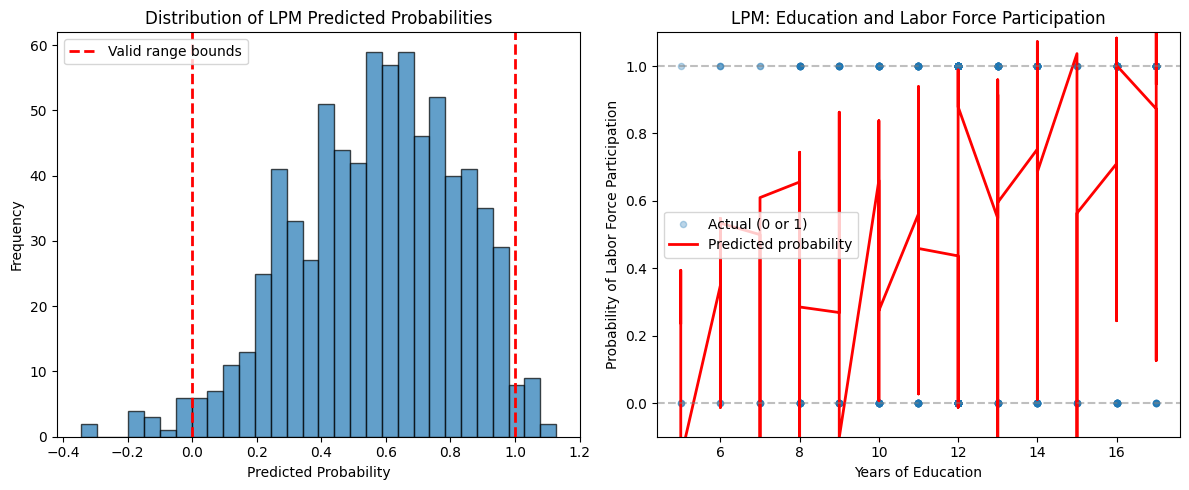

In [18]:
# Calculate predicted probabilities
mroz["pred_prob"] = results_lpm.fittedvalues

# Examine range of predicted probabilities
print(f"Range of predicted probabilities:")
print(f"Minimum: {mroz['pred_prob'].min():.4f}")
print(f"Maximum: {mroz['pred_prob'].max():.4f}")
print(f"\nProportion of predictions outside [0, 1]:")
outside_range = ((mroz["pred_prob"] < 0) | (mroz["pred_prob"] > 1)).sum()
print(f"{outside_range} out of {len(mroz)} ({100*outside_range/len(mroz):.2f}%)")

# Visualize predicted probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of predicted probabilities
ax1.hist(mroz["pred_prob"], bins=30, edgecolor="black", alpha=0.7)
ax1.axvline(0, color="red", linestyle="--", linewidth=2, label="Valid range bounds")
ax1.axvline(1, color="red", linestyle="--", linewidth=2)
ax1.set_xlabel("Predicted Probability")
ax1.set_ylabel("Frequency")
ax1.set_title("Distribution of LPM Predicted Probabilities")
ax1.legend()

# Predicted vs actual
ax2.scatter(
    mroz["educ"],
    mroz["inlf"],
    alpha=0.3,
    label="Actual (0 or 1)",
    s=20,
)
# Sort by educ for smooth line
mroz_sorted = mroz.sort_values("educ")
ax2.plot(
    mroz_sorted["educ"],
    mroz_sorted["pred_prob"],
    color="red",
    linewidth=2,
    label="Predicted probability",
)
ax2.axhline(0, color="gray", linestyle="--", alpha=0.5)
ax2.axhline(1, color="gray", linestyle="--", alpha=0.5)
ax2.set_xlabel("Years of Education")
ax2.set_ylabel("Probability of Labor Force Participation")
ax2.set_title("LPM: Education and Labor Force Participation")
ax2.legend()
ax2.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

**Key Limitations of the LPM:**

1. **Nonsensical predictions:** Fitted values can fall outside the $[0, 1]$ interval, which is problematic for probabilities
2. **Heteroskedasticity:** The error variance is inherently heteroskedastic: $\text{Var}(u_i | \mathbf{x}) = p_i(1 - p_i)$ where $p_i$ is the true probability
3. **Constant marginal effects:** The LPM assumes the effect of $x_j$ on the probability is constant across all values of $x$, which may be unrealistic
4. **Linearity assumption:** True relationship between covariates and probabilities may be nonlinear

**When to use LPM:**

- Quick approximation and interpretation of effects
- When most predicted probabilities fall within $[0, 1]$
- For small to moderate effects where linearity is reasonable
- As a benchmark to compare with nonlinear models (probit, logit)

**Addressing heteroskedasticity:**

Since LPM has heteroskedastic errors by construction, we should use **heteroskedasticity-robust standard errors** (covered in Chapter 8):

In [19]:
# Re-estimate with robust standard errors
results_lpm_robust = lpm.fit(cov_type="HC3")

# Compare standard errors
comparison = pd.DataFrame(
    {
        "Coefficient": round(results_lpm.params, 6),
        "SE (usual)": round(results_lpm.bse, 6),
        "SE (robust)": round(results_lpm_robust.bse, 6),
    },
)
print("\nComparison of Standard Errors:")
comparison


Comparison of Standard Errors:


,Coefficient,SE (usual),SE (robust)
Intercept,0.585519,0.154178,0.153580
nwifeinc,-0.003405,0.001448,0.001558
educ,0.037995,0.007376,0.007340
exper,0.039492,0.005673,0.005984
I(exper ** 2),-0.000596,0.000185,0.000199
age,-0.016091,0.002485,0.002415
kidslt6,-0.261810,0.033506,0.032152
kidsge6,0.013012,0.013196,0.013660


**Interpretation:**

The robust standard errors account for heteroskedasticity and are generally larger than the usual OLS standard errors. When using LPM, always report robust standard errors for valid inference.

**Connection to later chapters:**

- Chapter 8 discusses heteroskedasticity and robust standard errors in detail
- Chapter 17 introduces **probit** and **logit** models, which constrain predicted probabilities to $[0, 1]$ and allow for nonlinear probability responses

## 7.7 Policy Analysis and Program Evaluation

Dummy variables are essential tools for evaluating the effects of policy interventions and programs. When units (individuals, firms, regions) receive a treatment or participate in a program, we can use a **treatment dummy** to estimate the average treatment effect while controlling for observable characteristics.

### 7.7.1 Regression Adjustment for Treatment Effects

The basic program evaluation model is:

$$
y_i = \beta_0 + \delta_0 D_i + \beta_1 x_{i1} + \cdots + \beta_k x_{ik} + u_i
$$

where:

- $D_i = 1$ if unit $i$ received the treatment (participated in program), 0 otherwise
- $\delta_0$ is the **average treatment effect** (ATE) controlling for $x$ variables
- $x$ variables are pre-treatment characteristics (covariates)

**Interpretation:**

- $\delta_0$ measures the average difference in outcomes between treatment and control groups, **holding all other covariates constant**
- This is called **regression adjustment** because we adjust for observable differences between treatment and control groups
- If treatment is randomly assigned and $x$ variables are pre-treatment, $\delta_0$ has a causal interpretation

### 7.7.2 Example: Job Training Program Evaluation

Consider evaluating a job training program's effect on earnings. We use hypothetical data similar to Wooldridge Example 7.9:

In [20]:
# Simulate job training data (similar structure to real evaluations)
np.random.seed(42)
n = 500

# Generate covariates (pre-treatment characteristics)
educ = np.random.randint(10, 17, n)  # Years of education (10-16)
age = np.random.randint(22, 55, n)  # Age (22-54)
prior_earn = np.random.gamma(3, 5, n)  # Prior earnings (in thousands)

# Treatment assignment (not fully random - selection bias)
# People with lower prior earnings more likely to participate
prob_treat = 0.3 + 0.2 * (prior_earn < prior_earn.mean())
treatment = np.random.binomial(1, prob_treat)

# Generate outcome (post-program earnings)
# True treatment effect is $3,000
earnings = (
    2
    + 1.5 * educ
    + 0.3 * age
    + 0.8 * prior_earn
    + 3 * treatment  # True ATE = 3 (thousands)
    + np.random.normal(0, 4, n)
)

# Create DataFrame
train_data = pd.DataFrame(
    {
        "earnings": earnings,
        "treatment": treatment,
        "educ": educ,
        "age": age,
        "prior_earn": prior_earn,
    },
)

print(f"Sample size: {n}")
print(f"Treatment group: {treatment.sum()} ({100*treatment.mean():.1f}%)")
print(f"Control group: {(1-treatment).sum()} ({100*(1-treatment).mean():.1f}%)")

Sample size: 500
Treatment group: 198 (39.6%)
Control group: 302 (60.4%)


**Naive comparison (without regression adjustment):**

In [21]:
# Simple mean difference (biased if groups differ in observables)
mean_treat = train_data[train_data["treatment"] == 1]["earnings"].mean()
mean_control = train_data[train_data["treatment"] == 0]["earnings"].mean()
naive_effect = mean_treat - mean_control

print(f"\nNaive Comparison (Simple Difference in Means):")
print(f"Average earnings (treatment group): ${mean_treat:.2f}k")
print(f"Average earnings (control group): ${mean_control:.2f}k")
print(f"Naive treatment effect: ${naive_effect:.2f}k")


Naive Comparison (Simple Difference in Means):
Average earnings (treatment group): $45.98k
Average earnings (control group): $45.82k
Naive treatment effect: $0.16k


This naive comparison may be biased if treatment and control groups differ in characteristics like education, age, or prior earnings.

**Regression-adjusted estimate:**

In [22]:
# Estimate with regression adjustment
eval_model = smf.ols(
    formula="earnings ~ treatment + educ + age + prior_earn",
    data=train_data,
)
results_eval = eval_model.fit()

# Display results
table_eval = pd.DataFrame(
    {
        "b": round(results_eval.params, 4),
        "se": round(results_eval.bse, 4),
        "t": round(results_eval.tvalues, 4),
        "pval": round(results_eval.pvalues, 4),
    },
)
print("\nRegression-Adjusted Treatment Effect:")
table_eval


Regression-Adjusted Treatment Effect:


,b,se,t,pval
Intercept,1.8057,1.3787,1.3097,0.1909
treatment,2.7657,0.3678,7.5198,0.0000
educ,1.4843,0.0884,16.7986,0.0000
age,0.3119,0.0182,17.1168,0.0000
prior_earn,0.7929,0.0198,40.0013,0.0000


**Interpretation:**

- The coefficient on `treatment` is the **regression-adjusted treatment effect**
- This controls for differences in education, age, and prior earnings between groups
- The adjusted estimate should be closer to the true effect ($3,000) than the naive comparison
- Standard error on `treatment` coefficient allows us to test $H_0: \delta_0 = 0$ (no treatment effect)

### 7.7.3 Difference-in-Differences with Dummies

When we have data before and after program implementation, we can use **difference-in-differences (DD)** to control for time-invariant unobservables:

$$
y_{it} = \beta_0 + \delta_0 (D_i \times \text{After}_t) + \beta_1 D_i + \beta_2 \text{After}_t + \mathbf{x}_{it}'\boldsymbol{\beta} + u_{it}
$$

where:

- $D_i = 1$ for treatment group, 0 for control group
- $\text{After}_t = 1$ for post-treatment period, 0 for pre-treatment
- $D_i \times \text{After}_t$ is the **interaction term** (treatment effect)
- $\delta_0$ is the DD estimator of the treatment effect

**Intuition:**

- $\beta_1$: Pre-existing difference between treatment and control groups
- $\beta_2$: Time trend affecting both groups
- $\delta_0$: Additional change in treatment group beyond time trend

In [23]:
# Simulate difference-in-differences data
np.random.seed(123)
n_units = 250  # Units per group
n_total = n_units * 2 * 2  # 2 groups * 2 time periods

# Create panel structure
unit_id = np.repeat(np.arange(n_units * 2), 2)
time = np.tile([0, 1], n_units * 2)  # 0 = before, 1 = after
treated = np.repeat([0, 1], n_units * 2)  # First 250 control, next 250 treated

# Interaction term
treat_after = treated * time

# Generate outcome with true DD effect of 5
# treated units have higher baseline (3)
# time trend is 2 for everyone
# treatment effect is 5
y_dd = (
    10
    + 3 * treated  # Pre-existing difference
    + 2 * time  # Time trend
    + 5 * treat_after  # Treatment effect
    + np.random.normal(0, 3, n_total)
)

dd_data = pd.DataFrame(
    {
        "y": y_dd,
        "treated": treated,
        "after": time,
        "treat_after": treat_after,
        "unit_id": unit_id,
    },
)

# Estimate DD model
dd_model = smf.ols(formula="y ~ treated + after + treat_after", data=dd_data)
results_dd = dd_model.fit()

# Display results
table_dd = pd.DataFrame(
    {
        "b": round(results_dd.params, 4),
        "se": round(results_dd.bse, 4),
        "t": round(results_dd.tvalues, 4),
        "pval": round(results_dd.pvalues, 4),
    },
)
print("\nDifference-in-Differences Estimation:")
table_dd


Difference-in-Differences Estimation:


,b,se,t,pval
Intercept,9.9474,0.1902,52.2959,0.0
treated,2.8523,0.2690,10.6032,0.0
after,1.8734,0.2690,6.9643,0.0
treat_after,5.2844,0.3804,13.8908,0.0


**Interpretation:**

- `treated`: Pre-treatment difference between groups (approximately 3)
- `after`: Common time trend (approximately 2)
- `treat_after`: **DD estimate** of treatment effect (approximately 5)
- The DD estimator controls for time-invariant differences between groups and common time trends

**Key assumptions:**

- **Parallel trends:** Without treatment, both groups would have followed the same trend
- **No spillovers:** Control group not affected by treatment group's participation
- **Stable composition:** Groups don't change composition over time

## 7.8 Testing for Structural Breaks: The Chow Test

When we suspect that a regression relationship differs across groups or time periods, we can formally test for **structural breaks** using the **Chow test**. This F-test determines whether coefficients differ significantly between subsamples.

### 7.8.1 The Chow Test for Different Regression Functions

Suppose we have data from two groups (or time periods) and want to test whether the regression function is the same for both.

**Pooled model** (assumes same coefficients):

$$
y_i = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_k x_{ik} + u_i \quad \text{for all } i
$$

**Separate models** (allows different coefficients):

$$
\begin{aligned}
y_i &= \beta_{0,1} + \beta_{1,1} x_{i1} + \cdots + \beta_{k,1} x_{ik} + u_i \quad \text{for group 1} \\
y_i &= \beta_{0,2} + \beta_{1,2} x_{i1} + \cdots + \beta_{k,2} x_{ik} + u_i \quad \text{for group 2}
\end{aligned}
$$

**Chow test statistic:**

$$
F = \frac{(\text{SSR}_{\text{pooled}} - \text{SSR}_1 - \text{SSR}_2) / (k+1)}{(\text{SSR}_1 + \text{SSR}_2) / (n - 2(k+1))}
$$

where:

- $\text{SSR}_{\text{pooled}}$: Sum of squared residuals from pooled regression
- $\text{SSR}_1, \text{SSR}_2$: SSR from separate regressions for each group
- $k+1$: Number of restrictions (all coefficients equal)
- $n$: Total sample size

Under $H_0: \beta_{0,1} = \beta_{0,2}, \beta_{1,1} = \beta_{1,2}, \ldots, \beta_{k,1} = \beta_{k,2}$, the statistic follows $F_{k+1, n-2(k+1)}$.

### 7.8.2 Implementation using Interaction Terms

An equivalent way to conduct the Chow test is using an **interaction model**:

$$
y_i = \beta_0 + \delta_0 D_i + \beta_1 x_{i1} + \delta_1 (D_i \times x_{i1}) + \cdots + \beta_k x_{ik} + \delta_k (D_i \times x_{ik}) + u_i
$$

where $D_i = 1$ for group 2, 0 for group 1.

**Chow test as F-test:**

$$
H_0: \delta_0 = \delta_1 = \cdots = \delta_k = 0 \quad \text{(all interactions zero)}
$$

If we reject $H_0$, the regression functions differ significantly between groups.

### 7.8.3 Example: Testing for Gender Differences in Returns to Education

Let's test whether the wage-education relationship differs by gender:

In [24]:
# Use wage1 data
wage1 = wool.data("wage1")

# Pooled model (assumes same coefficients for males and females)
pooled_model = smf.ols(
    formula="np.log(wage) ~ educ + exper + I(exper**2) + tenure + I(tenure**2)",
    data=wage1,
)
results_pooled = pooled_model.fit()

# Separate regressions
# Male model
male_model = smf.ols(
    formula="np.log(wage) ~ educ + exper + I(exper**2) + tenure + I(tenure**2)",
    data=wage1,
    subset=(wage1["female"] == 0),
)
results_male = male_model.fit()

# Female model
female_model = smf.ols(
    formula="np.log(wage) ~ educ + exper + I(exper**2) + tenure + I(tenure**2)",
    data=wage1,
    subset=(wage1["female"] == 1),
)
results_female = female_model.fit()

# Compute Chow test statistic
SSR_pooled = results_pooled.ssr
SSR_male = results_male.ssr
SSR_female = results_female.ssr
SSR_unrestricted = SSR_male + SSR_female

n = len(wage1)
k = 5  # Number of slope coefficients (excluding intercept)
df1 = k + 1  # Restrictions (all coefficients)
df2 = n - 2 * (k + 1)  # Unrestricted model df

chow_stat = ((SSR_pooled - SSR_unrestricted) / df1) / (SSR_unrestricted / df2)
chow_pval = 1 - stats.f.cdf(chow_stat, df1, df2)

print("\nChow Test for Structural Break (Gender Differences):")
print(f"SSR pooled: {SSR_pooled:.4f}")
print(f"SSR unrestricted (male + female): {SSR_unrestricted:.4f}")
print(f"Chow F-statistic: {chow_stat:.4f}")
print(f"Degrees of freedom: ({df1}, {df2})")
print(f"P-value: {chow_pval:.6f}")
print(
    f"Critical value (5% level): {stats.f.ppf(0.95, df1, df2):.4f}",
)

if chow_pval < 0.05:
    print("\nConclusion: REJECT null hypothesis - significant structural break")
    print("The wage-education relationship differs significantly by gender")
else:
    print("\nConclusion: FAIL TO REJECT null hypothesis")
    print("No evidence of structural break by gender")


Chow Test for Structural Break (Gender Differences):
SSR pooled: 93.9113
SSR unrestricted (male + female): 79.9204
Chow F-statistic: 14.9968
Degrees of freedom: (6, 514)
P-value: 0.000000
Critical value (5% level): 2.1162

Conclusion: REJECT null hypothesis - significant structural break
The wage-education relationship differs significantly by gender


**Alternative: F-test on interaction model**

In [25]:
# Full interaction model
interact_model = smf.ols(
    formula="np.log(wage) ~ female * (educ + exper + I(exper**2) + tenure + I(tenure**2))",
    data=wage1,
)
results_interact = interact_model.fit()

# Test all interaction terms jointly
# This tests H0: all interaction coefficients = 0
# Equivalent to Chow test
interaction_terms = [
    "female:educ",
    "female:exper",
    "female:I(exper ** 2)",
    "female:tenure",
    "female:I(tenure ** 2)",
    "female",  # Different intercept
]

# F-test for joint significance
f_test_result = results_interact.f_test(
    " + ".join([f"{term} = 0" for term in interaction_terms]),
)

print("\nF-test on Interaction Terms (Equivalent to Chow Test):")
print(f"F-statistic: {f_test_result.fvalue:.4f}")
print(f"P-value: {f_test_result.pvalue:.6f}")
print("\nNote: This F-statistic should match the Chow test statistic")


F-test on Interaction Terms (Equivalent to Chow Test):
F-statistic: 14.9968
P-value: 0.000000

Note: This F-statistic should match the Chow test statistic


### 7.8.4 Chow Test with Different Intercepts Only

Sometimes we want to test only if intercepts differ (not slopes). This is a restricted version:

$$
H_0: \delta_0 = 0 \quad \text{(only intercept difference, slopes same)}
$$

This is simply a t-test on a single dummy variable:

In [26]:
# Model with only intercept difference (no slope interactions)
intercept_only = smf.ols(
    formula="np.log(wage) ~ female + educ + exper + I(exper**2) + tenure + I(tenure**2)",
    data=wage1,
)
results_intercept = intercept_only.fit()

# Extract female coefficient (intercept shift)
female_coef = results_intercept.params["female"]
female_se = results_intercept.bse["female"]
female_t = results_intercept.tvalues["female"]
female_p = results_intercept.pvalues["female"]

print("\nTest for Different Intercepts Only (Same Slopes):")
print(f"Female coefficient (intercept shift): {female_coef:.6f}")
print(f"Standard error: {female_se:.6f}")
print(f"t-statistic: {female_t:.4f}")
print(f"p-value: {female_p:.6f}")

if female_p < 0.05:
    print("\nConclusion: Intercepts differ significantly by gender")
    print("(but this doesn't test whether slopes also differ)")


Test for Different Intercepts Only (Same Slopes):
Female coefficient (intercept shift): -0.296511
Standard error: 0.035805
t-statistic: -8.2812
p-value: 0.000000

Conclusion: Intercepts differ significantly by gender
(but this doesn't test whether slopes also differ)


**Interpretation:**

- The full Chow test (or F-test on all interactions) tests whether **any** coefficients differ
- The intercept-only test is more restrictive and asks only whether the baseline wage differs
- If the full Chow test rejects but the intercept-only test doesn't, this suggests slopes differ even if intercepts don't

**Key insight:**

The Chow test is essentially the same as testing the joint significance of all interaction terms in a fully interacted model. The interaction approach is more flexible because you can:

1. Test for different intercepts only (one dummy)
2. Test for different slopes only (slope interactions)
3. Test for any differences (all interactions including intercept)

This provides a comprehensive framework for testing structural stability across groups or time periods.

## Chapter Summary

Chapter 7 introduced qualitative (categorical) regressors into the multiple regression framework, expanding our ability to model economic relationships and evaluate policies.

### Key Concepts

**Dummy Variables:**

- Binary variables taking values 0 or 1 to represent categories
- Interpretation: $\beta_{\text{dummy}}$ is the average difference between groups, holding other variables constant
- In log models: Percentage difference $\approx 100 \times \beta_{\text{dummy}}$ (exact: $100 \times [\exp(\beta) - 1]$)
- Always exclude one category (reference group) to avoid perfect multicollinearity

**Multiple Categories:**

- Use $J-1$ dummies for $J$ categories
- Coefficients measure differences relative to the omitted reference group
- F-tests can test overall significance of categorical variables
- ANOVA tables decompose variation within and between groups

**Interactions:**

- **Dummy-continuous:** Allow slope of continuous variable to differ across groups
  - $y = \beta_0 + \delta_0 D + \beta_1 x + \delta_1 (D \times x)$
  - For group $D=0$: slope is $\beta_1$
  - For group $D=1$: slope is $\beta_1 + \delta_1$
- **Dummy-dummy:** Allow effect of one dummy to vary across another dummy
  - Interaction coefficient is the additional effect when both dummies are 1
- **Full interactions:** Allow complete regression functions (intercepts and all slopes) to differ across groups

**Linear Probability Model (LPM):**

- OLS regression with binary (0/1) dependent variable
- Fitted values are estimated probabilities: $\hat{P}(y=1|\mathbf{x})$
- Coefficients represent marginal effects on probabilities (in percentage points)
- Limitations: Predictions outside $[0,1]$, heteroskedastic errors, constant marginal effects
- Always use robust standard errors with LPM
- Alternative models: Probit and logit (Chapter 17)

**Policy Evaluation:**

- **Regression adjustment:** Control for observable differences using covariates
  - Treatment effect $\delta$ from: $y = \beta_0 + \delta D_{\text{treat}} + \mathbf{x}'\boldsymbol{\beta} + u$
- **Difference-in-differences:** Control for time-invariant unobservables
  - DD estimator from: $y = \beta_0 + \delta_0 (D \times \text{After}) + \beta_1 D + \beta_2 \text{After} + u$
  - Requires parallel trends assumption

**Chow Test:**

- Formal test for structural breaks (parameter stability across groups/time)
- Tests $H_0$: All coefficients equal across groups
- Implementation: Compare pooled vs separate regressions, or F-test on interactions
- Flexible: Can test different intercepts only, different slopes only, or all differences

### Python Implementation Patterns

**Creating dummy variables:**

- Automatic with categorical in formula: `y ~ C(region) + x1 + x2`
- Manual creation: `data["female"] = (data["sex"] == "F").astype(int)`
- Multiple categories: `pd.get_dummies(data["occupation"], drop_first=True, prefix="occ")`

**Interactions in formulas:**

- Dummy-continuous: `y ~ female * educ` expands to `female + educ + female:educ`
- Full interaction: `y ~ female * (educ + exper + tenure)` includes all interactions

**Testing with F-tests:**

- Joint significance: `results.f_test("C(region)[T.midwest] = 0, C(region)[T.south] = 0")`
- Chow test: `results.f_test("female = 0, female:educ = 0, female:exper = 0")`

**Robust standard errors:**

- For LPM and heteroskedasticity: `model.fit(cov_type="HC3")`

### Common Pitfalls

1. **Dummy variable trap:** Including all categories plus intercept causes perfect multicollinearity. Always exclude one reference group.

2. **Misinterpreting log models:** In $\log(y) = \beta_0 + \delta D + \cdots$, the coefficient $\delta$ is NOT the percentage difference. Use $100 \times [\exp(\delta) - 1]$ for exact percentage.

3. **Ignoring heteroskedasticity in LPM:** LPM has heteroskedastic errors by construction. Always use robust standard errors.

4. **Extrapolating LPM:** Predictions outside $[0,1]$ are nonsensical. LPM works best when most fitted values are in $(0.2, 0.8)$.

5. **Confusing treatment assignment with treatment effect:** Selection bias occurs when treatment group differs from control group in unobservables. Regression adjustment only controls for observables.

6. **Forgetting interaction interpretation:** When $x_1$ and $x_2$ interact, the marginal effect of $x_1$ depends on the value of $x_2$ (and vice versa).

### Connections

**To previous chapters:**

- **Chapter 3:** Dummy variables extend multiple regression to qualitative data
- **Chapter 4:** Same inference tools (t-tests, F-tests) apply to dummy coefficients
- **Chapter 6:** Interaction terms as generalization of functional form flexibility

**To later chapters:**

- **Chapter 8:** Heteroskedasticity-robust inference critical for LPM
- **Chapter 13-14:** Panel data methods extend difference-in-differences
- **Chapter 15:** Instrumental variables for endogenous treatment assignment
- **Chapter 17:** Probit and logit models for binary outcomes (nonlinear alternatives to LPM)

### Practical Guidance

**When to use dummy variables:**

- Modeling discrete categories (gender, region, industry)
- Capturing seasonal or time effects
- Policy evaluation (treatment/control comparisons)
- Testing parameter stability (Chow test framework)

**Choosing reference group:**

- Pick largest or most natural comparison group
- Be explicit about omitted category in interpretation
- Results are invariant to choice (same F-tests), but interpretation changes

**Interaction modeling strategy:**

1. Start simple: Test dummy main effect only
2. If theoretically motivated, add interactions
3. Test joint significance of interactions (F-test)
4. If interactions significant, interpret using predicted values or marginal effects at different values

**Program evaluation best practices:**

- Check balance of covariates across treatment/control groups
- Use robust standard errors
- If treatment not random, consider IV methods (Chapter 15) or panel methods (Chapters 13-14)
- Report both naive (unadjusted) and regression-adjusted estimates for transparency

**Reporting results:**

- Clearly state reference group for categorical variables
- For interactions, show predicted effects at meaningful values of moderating variables
- Use visualization (predicted values plots) to clarify interaction effects
- For LPM, always note predictions outside $[0,1]$ and use robust SEs

### Learning Objectives Covered

1. **7.1:** Define dummy variables and provide examples
2. **7.2:** Interpret dummy variable coefficients in various functional forms
3. **7.3:** Understand interactions among dummy variables
4. **7.4:** Interpret interactions between dummy and continuous variables
5. **7.5:** Incorporate multiple categorical variables using multiple dummies
6. **7.6:** Understand purpose of Chow test for parameter stability
7. **7.7:** Implement Chow test with different intercepts (restricted version)
8. **7.8:** Define and interpret linear probability model for binary outcomes
9. **7.9:** Use regression adjustment for program evaluation
10. **7.10:** Interpret regression results with discrete dependent variables

This chapter provided the tools to handle qualitative information in regression analysis, enabling richer modeling of economic relationships and rigorous evaluation of policies and programs.